## Estimating the Importance of Missing Articles

Our goal is to Find Articles that should exist in the target language

#### Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from ConfigParser import SafeConfigParser
from operator import add
#from pyspark.mllib.recommendation import ALS, Rating
import random 
from random import randint
import itertools
from math import sqrt
import numpy as np
from pprint import pprint
import math
from ConfigParser import SafeConfigParser
import pandas as pd
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from eval_util import *

from sklearn import cross_validation, grid_search
from sklearn.cross_validation import StratifiedKFold
import multiprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from scipy.sparse import coo_matrix, hstack
import sklearn
from scipy.stats import spearmanr
from sklearn.metrics import f1_score, roc_auc_score,accuracy_score, make_scorer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler


def get_parser(names):
    def loadRecord(line):
        cells = line.strip().split('\t')
        return dict(zip(names, cells))
    return loadRecord


def get_X(M, df, index_col, feature_cols):
    if M is None or index_col is None:
        l = []
    else:
        l = [M[df[index_col]], ]
    for col in feature_cols:
         l.append(coo_matrix(df[col].astype('float')).T)
    return hstack(l).toarray()


def f1(x, y):
    sr = f1_score(x, y)
    print 'F1: %2.5f' % sr
    return sr

def auc(y_true,y_pred):
    mse = roc_auc_score(y_true, y_pred)
    print 'ROC: %2.5f \n' % mse
    return mse

def acc(y_true,y_pred):    
     r2 = accuracy_score(y_true, y_pred)
     print 'Accuracy: %2.5f' % r2
     return r2

def multi_score_classification(y_true,y_pred):   
    f1(y_true,y_pred) #set score here and not below if using MSE in GridCV
    acc(y_true,y_pred)
    score = auc(y_true,y_pred)
    return score

def multi_scorer_classification():
    return make_scorer(multi_score_classification, greater_is_better=True) # change for false if using MSE


def spearman(x, y):
    sr = spearmanr(x, y)[0]
    print 'Spearman: %2.5f \n' % sr
    return sr

def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print 'MSE: %2.5f' % mse
    return mse

def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print 'R2: %2.5f' % r2
     return r2

def multi_score_regression(y_true,y_pred):    
    MSE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    R2(y_true,y_pred)
    score = spearman(y_true,y_pred)
    return score

def multi_scorer_regression():
    return make_scorer(multi_score_regression, greater_is_better=True) # change for false if using MSE



    
def cv (X, y, folds, alg, param_grid, regression):
    """
    Determine the best model via cross validation. This should be run on training data.
    """
    if regression:
        scoring = multi_scorer_regression()
    else:
        scoring = multi_scorer_classification()
        
    print "\n\n\nDoing Gridsearch\n"

    kfold_cv = cross_validation.KFold(X.shape[0], n_folds=folds, shuffle=True)
    model = grid_search.GridSearchCV(cv  = kfold_cv, estimator = alg, param_grid = param_grid, scoring = scoring) #n_jobs=multiprocessing.cpu_count()
    model = model.fit(X,y)
    # model trained on all data
    y_pred = model.predict(X)
    
    if regression:
        print "Best Model Train MSE: %f" % sklearn.metrics.mean_squared_error(y, y_pred)
        print "Best Model Train Spearman %f" % spearman(y, y_pred)
    else:
        print "Best Model Train AUC: %f" % roc_auc_score(y, y_pred)
        print "Best Model Train F1 %f" % f1_score(y, y_pred)
        print "Best Model Train Accuracy %f" % accuracy_score(y, y_pred)
        


    print("\nBest parameters set found:")
    best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
    print(best_parameters, score)
    print "\n"
    print("Grid scores:")
    for params, mean_score, scores in model.grid_scores_:
        print("%0.5f (+/-%0.05f) for %r"
              % (mean_score, scores.std() / 2, params))

    return model

config = '/home/ellery/wikimedia/missing_articles/missing_articles.ini'
cp = SafeConfigParser()
cp.read(config)

['/home/ellery/wikimedia/missing_articles/missing_articles.ini']

In [2]:
# Predict if the source article exists in the target

In [3]:
s = 'en'
t = 'fr'
t_country_name = 'France'
exp_dir = '%s-%s' % (s, t)

In [5]:
#pv_df_final.to_csv('/home/ellery/'+exp_dir+'/pv_df.tsv', encoding = 'utf8', sep = '\t', index = False)
pv_df_final = pd.read_csv('/home/ellery/'+exp_dir+'/pv_df.tsv', encoding = 'utf8', sep = '\t')
pv_df_final['is_dis'] = pv_df_final['is_dis'].apply(lambda x: x =='True')
pv_df_final['is_stub'] = pv_df_final['is_stub'].apply(lambda x: x =='True')

In [6]:
countries = set(['France', 'Spain', 'Germany', 'Russia', 'Poland', 'Italy', 'Netherlands'])

#### Get Page View Counts and Ranks

In [7]:
other_langs = ['de', 'nl', 'it', 'es', 'en', 'fr', 'ru', 'pl']
langs = set(other_langs)
langs.add(s)
langs.add(t)

In [ ]:
def get_ranking_score(t):
    lang_id, items = t
    items = list(items)
    item_ranks = np.argsort(np.array([x['pageview_count'] for x in items]))
    n = float(len(items))
    for r, i in enumerate(item_ranks):
        items[i]['rank'] = r/n
    return items

def make_counts_float(x):
    x['pageview_count']  = int(x['pageview_count'])  
    return x  

def contains_source(dict_list):
    for d in dict_list:
        if s == d['lang']:
            return True
    return False
    
                                      
names = [ 'id', 'lang', 'title', 'pageview_count']

pv_features = sc.textFile(cp.get('general', 'pageviews'))\
.map(get_parser(names))\
.filter(lambda x: len(x) == 4)\
.filter(lambda x: ':' not in x['title'])\
.filter(lambda x: x['lang'] in langs)\
.map(make_counts_float)\
.map(lambda x: (x['lang'], x))\
.groupByKey()\
.flatMap(get_ranking_score)\
.map(lambda x: (x['id'], x))\
.groupByKey()\
.filter(lambda x: contains_source(x[1]))\
.flatMap(lambda x: x[1])\
.map(lambda x: (x['id'], x['lang'], x['pageview_count'], x['rank']))

pv_df = pd.DataFrame(pv_features.collect(), columns = [ 'id', 'lang', 'pageview_count', 'rank'])

df1 = pv_df.pivot(index='id', columns='lang', values='pageview_count')
df1.fillna(value=0, inplace=True)
df1.columns = ['pageview_count_' + lang for lang in df1.columns]

df2 = pv_df.pivot(index='id', columns='lang', values='rank')
df2.fillna(value=0, inplace=True)
df2.columns = ['rank_' + lang for lang in df2.columns]

pv_df_final = df1.merge(df2, right_index = True, left_index = True, how = 'inner')
del df1
del df2

#### Get Article Titles

In [6]:
names = [ 'id', 'lang', 'title']
item_names = sc.textFile(cp.get('general', 'id2article'))\
.map(get_parser(names))\
.filter(lambda x: len(x) == 3)\
.filter(lambda x: x['lang'] == s)\
.map(lambda x: (x['id'], x['title'])).collect()

ids = [x[0] for x in item_names]
names = [x[1] for x in item_names]
names_series = pd.Series(names, index=ids)
del ids
del names
pv_df_final['title'] = names_series
del names_series
del item_names

In [12]:
def underscore(x):
    return unicode(x).replace(u' ', u'_')

In [14]:
pv_df_final['title'] = pv_df_final['title'].apply(underscore)

#### Get Number of Wikis the Article Exists in

In [15]:
def count_non_target(x):
    res = 0
    for d in x:
        if t != d['lang']:
            res+=1
    return res

names = [ 'id', 'lang', 'title']
item_counts = sc.textFile(cp.get('general', 'id2article'))\
.map(get_parser(names))\
.filter(lambda x: len(x) == 3)\
.map(lambda x: (x['id'], x))\
.groupByKey()\
.filter(lambda x: contains_source(x[1]))\
.mapValues(count_non_target)\
.collect()

ids = [x[0] for x in item_counts]
counts = [x[1] for x in item_counts]
count_series = pd.Series(counts, index=ids)
del ids
del counts
pv_df_final['wiki_count'] = count_series
del count_series
del item_counts

#### Label Articles that exist in the target

In [16]:
names = [ 'id', 'lang', 'title']
target_items = sc.textFile(cp.get('general', 'id2article'))\
.map(get_parser(names))\
.filter(lambda x: len(x) == 3)\
.filter(lambda x: x['lang'] == t)\
.map(lambda x: x['id'])\
.collect()

joint_items = set(pv_df_final.index).intersection(set(target_items))
joint_items_series = pd.Series(1, index =list(joint_items))
pv_df_final['in_t'] = joint_items_series
pv_df_final['id'] = pv_df_final.index

In [17]:
del target_items
del joint_items
del joint_items_series

#### Get Geo Pageviews

In [18]:
# Views of Source Article from other countries
geo_file = "/user/ellery/enwiki_views_reduced.tsv"
names = ['title', 'country', 'count']
geo_pv = sc.textFile(geo_file)\
.map(get_parser(names))\
.filter(lambda x: len(x) == 3)\
.filter(lambda x: x['country'] in countries)\
.map(lambda x: (x['title'], x['country'], int(x['count'])))\
.collect()

geo_pv_df = pd.DataFrame(geo_pv, columns = names)
geo_pv_df = geo_pv_df.pivot(index='title', columns='country', values='count')
geo_pv_df.fillna(value=0, inplace=True)

In [41]:
geo_pv_df.columns = ['pageviews_for_s_from_' + c for c in geo_pv_df.columns]

In [43]:
geo_pv_df['title'] = geo_pv_df.index

In [44]:
geo_pv_df['title'] = geo_pv_df['title'].apply(underscore)

In [45]:
pv_df_final = pv_df_final.merge(geo_pv_df, how = 'left', on = 'title')

In [11]:
del geo_pv
del geo_pv_df

#### Get Log Pageview counts

In [8]:
pageview_counts = ['pageviews_for_s_from_' + c for c in countries] + ['pageview_count_' + lang for lang in langs if lang != t]
log_pageview_counts = ['log_' + c for c in pageview_counts]

In [49]:
pv_df_final[log_pageview_counts] = pv_df_final[pageview_counts].replace(0, 1).apply(np.log)

#### Get Edit Features

In [50]:
def months_ago(date):
    year = int(date[:4])
    month = int(date[4:6])
    return (2015*12 + 6) - (year*12+month)

revisions_file = '/user/west1/revision_history_aggregated/' + s
names = ['lang','user_id','user','mid','page_title','num_edits','timestamp','bytes_added']
revisions = sc.textFile(revisions_file)\
.map(get_parser(names))\
.filter(lambda x: len(x) == 8)\
.map(lambda x: (x['mid'], x['timestamp']))\
.groupByKey()\
.map(lambda x: (x[0], len(x[1]), months_ago(min(x[1])), months_ago(max(x[1]))))\

edit_features_df = pd.DataFrame(revisions.collect(), columns = ['id', 'num_contributors', 'first_date', 'last_date'] )

In [52]:
pv_df_final = pv_df_final.merge(edit_features_df, how = 'left', on = 'id')
pv_df_final.fillna(value=0, inplace=True)

In [55]:
del edit_features_df

#### Get Dump Features

In [56]:
feature_file = "/home/ellery/en-en/dump_features.tsv"
dump_df = pd.read_csv(feature_file, encoding = 'utf8', sep = '\t')
del dump_df['Unnamed: 0']
dump_df['title'] = dump_df['title'].apply(lambda x: unicode(x).replace(u' ', u'_'))
dump_df['log_length'] = dump_df['length'].apply(np.log)
pv_df_final = pv_df_final.merge(dump_df, how = 'left',on = 'title')
pv_df_final.fillna(value=0, inplace=True)

In [57]:
del dump_df

#### Get Importance Template Label Features

In [59]:
importance_file = '/home/ellery/importance.tsv'
importance_df = pd.read_csv(importance_file, encoding = 'utf8', sep = '\t')
importance_df.columns = ['title', 'score']
importance_df['group'] = importance_df['score']
importance_df = importance_df[importance_df['title'].notnull()]
importance_df_pivoted = importance_df.pivot(index='title', columns='group', values='score')
importance_df_pivoted[importance_df_pivoted.notnull()] = 1
importance_df_pivoted.fillna(0, inplace = True)
importance_df_pivoted.columns =  ['unk', 'low', 'mid', 'high', 'top']
del importance_df_pivoted['unk']

In [62]:
importance_df_pivoted['title'] = importance_df_pivoted.index

In [63]:
importance_df_pivoted['title'] = importance_df_pivoted['title'].apply(underscore)

In [65]:
pv_df_final = pv_df_final.merge(importance_df_pivoted, how = 'left',on = 'title')

In [67]:
del importance_df_pivoted
del importance_df

### Get Link Features

In [68]:
subset = pv_df_final[['title', 'in_t']]
subset = subset[subset['in_t'] ==1]
tuples = [tuple(x) for x in subset.values]
target_item_rdd = sc.parallelize(tuples)
target_item_rdd.persist()

ParallelCollectionRDD[38] at parallelize at PythonRDD.scala:376

In [70]:
target_item_rdd.take(3)

[(u'Universe', 1.0), (u'Boston', 1.0), (u'Gabon', 1.0)]

In [73]:
from operator import add
links_file = '/user/hive/warehouse/ellery.db/pagelinks_readable'
  
links = sc.textFile(links_file)\
.map(lambda x: tuple(x.split(u'\x01')))

out_link_counts = links.map(lambda x: (x[0], 1))\
.reduceByKey(add)
out_link_counts.persist()

PythonRDD[48] at RDD at PythonRDD.scala:42

In [83]:
out_link_counts.take(10)

[(u'Neue_Haas_Grotesk', 1),
 (u'The_Terror_(Marvel_comics)', 1),
 (u'1940_World_Snooker_Championship', 99),
 (u'Pennsylvania_Route_830', 34),
 (u'Senait_Mehari', 1),
 (u'C.R._Eklund', 1),
 (u'1688_in_music', 51),
 (u'Brimsdown_Rovers_F.C.', 40),
 (u'\U0001308b', 1),
 (u'Nampu', 118)]

In [84]:
out_df  = pd.DataFrame(out_link_counts.collect(), columns = ['title', 'out_link_count'])
pv_df_final = pv_df_final.merge(out_df, how = 'left', on = 'title')

In [85]:
in_link_counts = links.map(lambda x: (x[1], 1))\
.reduceByKey(add)
in_link_counts.persist()

PythonRDD[83] at RDD at PythonRDD.scala:42

In [86]:
in_link_counts.take(10)

[(u'United_States_House_of_Representatives_elections_in_Oregon,_1996', 160),
 (u'Christopher_Bentley', 83),
 (u'West_La_Crosse,_Wisconsin', 36),
 (u'List_of_people_with_surname_Yu', 3),
 (u'Iliana_Raeva', 13),
 (u'North_Country_(soundtrack)', 3),
 (u'The_Stark_Munro_Letters', 37),
 (u'Annisa_Ananda_Nusyirwan', 71),
 (u'TuS_Wengern', 1),
 (u'SS_Delphic', 84)]

In [87]:
in_df  = pd.DataFrame(in_link_counts.collect(), columns = ['title', 'in_link_count'])
pv_df_final = pv_df_final.merge(in_df, how = 'left', on = 'title')

In [71]:
# Target Reduction

In [74]:
source_out_link_counts = links.join(target_item_rdd)\
.map(lambda x: tuple(x[1]))\
.reduceByKey(add)
source_out_link_counts.persist()

PythonRDD[61] at RDD at PythonRDD.scala:42

In [75]:
source_out_link_counts.take(100)

[(u'Lumber_River_Council_of_Governments', 5.0),
 (u'1940_World_Snooker_Championship', 74.0),
 (u'1946_in_architecture', 30.0),
 (u'George_Abercromby,_2nd_Baron_Abercromby', 3.0),
 (u'Cartersville,_Cumberland_County,_Virginia', 4.0),
 (u'Christopher_Bentley', 22.0),
 (u'F\xf8rde_Municipality', 1.0),
 (u'Fountain_Tree', 1.0),
 (u'Sepsiszentgy\xf6rgy', 1.0),
 (u'Multiple_familial_trichoepithelioma', 15.0),
 (u'Mazraeh-ye_Gura', 1.0),
 (u'Isa_Mohammed', 2.0),
 (u'Kharkiv_National_Aerospace_University_"KhAI"', 1.0),
 (u'Communist_states', 22.0),
 (u'Diego_Accorsi', 1.0),
 (u'Chill\xe1n_Department', 2.0),
 (u'Chatham,_Mississippi', 7.0),
 (u'David_Mueller', 1.0),
 (u'Yuthasak_Sasiprapha', 2.0),
 (u'Kelsey,_Texas', 3.0),
 (u'Kahlil_Gibran', 26.0),
 (u'New_Hanover_Island', 69.0),
 (u'Phu_Khiao_Wildlife_Sanctuary', 1.0),
 (u'Barbalin,_Western_Australia', 1.0),
 (u'Prinia_sylvatica', 2.0),
 (u'Base36', 10.0),
 (u'Hells_Kitchen_(band)', 1.0),
 (u'Six_Pack_Annie', 2.0),
 (u'Wisconsin_140hp', 1.0),

In [76]:
s_out_df  = pd.DataFrame(source_out_link_counts.collect(), columns = ['title', 'source_in_link_count'])
pv_df_final = pv_df_final.merge(s_out_df, how = 'left', on = 'title')

In [78]:
pv_df_final.head()[['title', 'source_in_link_count']]

,title,source_in_link_count
0,Universe,955
1,Boston,5483
2,Gabon,2685
3,Dutch_Wikipedia,107
4,Cadier_en_Keer,8


In [79]:
source_in_link_counts = links.map(lambda x: (x[1], x[0])).join(target_item_rdd)\
.map(lambda x: tuple(x[1]))\
.reduceByKey(add)
source_in_link_counts.persist()

PythonRDD[75] at RDD at PythonRDD.scala:42

In [80]:
source_in_link_counts.take(10)

[(u'Peel_Z-1_Glider_Boat', 34.0),
 (u'Leon_Bonnat', 1.0),
 (u'1946_in_architecture', 39.0),
 (u'William_Cook_(cricketer)', 10.0),
 (u'Cornelius_Wiebe', 12.0),
 (u'Cartersville,_Cumberland_County,_Virginia', 12.0),
 (u'La_lojban.', 1.0),
 (u'If_Not_Us_Who', 1.0),
 (u'Christopher_Bentley', 39.0),
 (u'1940_World_Snooker_Championship', 86.0)]

In [81]:
s_in_df  = pd.DataFrame(source_in_link_counts.collect(), columns = ['title', 'source_out_link_count'])
pv_df_final = pv_df_final.merge(s_in_df, how = 'left', on = 'title')

In [88]:
pv_df_final.head()[['title', 'source_out_link_count', 'source_in_link_count', 'out_link_count', 'in_link_count' ]]

,title,source_out_link_count,source_in_link_count,out_link_count,in_link_count
0,Universe,536,955,755,1690
1,Boston,701,5483,1181,20316
2,Gabon,359,2685,502,7233
3,Dutch_Wikipedia,105,107,115,153
4,Cadier_en_Keer,7,8,9,12


In [89]:
pv_df_final.fillna(value=0, inplace=True)

In [ ]:
del s_in_df
del s_out_df
del in_df
del out_df

In [ ]:
source_out_link_counts.unpersist()
in_link_counts.unpersist()
out_link_counts.unpersist()
source_in_link_counts.unpersist()

#### Get Topic Features

In [10]:
# Load doc vectors
lda_dir = 'en_lda'
base_dir = os.path.join(cp.get('general', 'local_data_dir'), lda_dir)
dict_file = os.path.join(base_dir, cp.get('LDA', 'article2index'))
id2index, _ , _ = get_universal_maps(dict_file)

In [11]:
mm_file = os.path.join(base_dir, cp.get('LDA', 'doc2topic'))
f = open(mm_file)
M = mmread(f).tocsr()

In [12]:
# Merge 
id2index_df = pd.DataFrame(id2index.items(), columns = ['id', 'indx'])
pv_df_final = pv_df_final.merge(id2index_df, on = 'id', how = 'inner')

### Subsample Data for Model Building

In [13]:
# code for sub-sampling training data
fraction = 1.0
rows = random.sample(pv_df_final.index, int(fraction*pv_df_final.shape[0]))
df_sample = pv_df_final.ix[rows]
df_sample_reg  = df_sample[df_sample['in_t'] ==1]

#### Baselines

In [14]:
print df_sample['in_t'].sum() / float(df_sample.shape[0])

0.215454074252


In [15]:
# Just en_ranks and views
features = []
features = pageview_counts + log_pageview_counts
features += ['rank_' + lang for lang in langs if lang != t]
features.append('wiki_count')
features += ['length', 'is_dis', 'is_stub', 'log_length']
features += ['num_contributors', 'first_date', 'last_date']
features += ['source_out_link_count', 'source_in_link_count', 'out_link_count', 'in_link_count' ]
features += ['low', 'mid', 'high', 'top']

In [16]:
#features

In [17]:
from sklearn.cross_validation import train_test_split

def evaluate(X, y, alg, regression, retmodel = False):
    
    
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
    model = alg.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    if not regression:
        y_train_proba = model.predict_proba (X_train)[:, 1]
        y_test_proba  = model.predict_proba (X_test)[:, 1]
        
    
    if regression:
        print "Train MSE: %f" % sklearn.metrics.mean_squared_error(y_train, y_train_pred)
        print "Test MSE: %f" % sklearn.metrics.mean_squared_error(y_test, y_test_pred)
        
        print "\nTrain Spearman %f" % spearmanr(y_train, y_train_pred)[0]
        print "Test Spearman %f" % spearmanr(y_test, y_test_pred)[0]

    else:
        
        print "Train AUC: %f" % roc_auc_score(y_train, y_train_proba)
        print "Test AUC: %f" % roc_auc_score(y_test, y_test_proba)

        print "\nTrain F1 %f" % f1_score(y_train, y_train_pred)
        print "Test F1 %f" % f1_score(y_test, y_test_pred)

        print "\nTrain Accuracy %f" % accuracy_score(y_train, y_train_pred)
        print "Test Accuracy %f" % accuracy_score(y_test, y_test_pred)
        
    
    if retmodel:
        return alg.fit(X,y)
        

In [18]:
y = df_sample_reg['rank_%s' % t].astype('float').values
X = get_X(M, df_sample_reg, 'indx', features)
scaler = StandardScaler().fit(X)
X = scaler.transform(X) 
rank_model = evaluate(X, y, LinearRegression(), True, retmodel = True)

Train MSE: 0.024029
Test MSE: 0.024078

Train Spearman 0.849222
Test Spearman 0.849009


In [19]:
y = df_sample['in_t'].astype('int').values
X = get_X(None, df_sample, None, features)
scaler = StandardScaler().fit(X)
X = scaler.transform(X) 
class_model = evaluate(X, y, LogisticRegression(max_iter=5, C = 1.0), False, retmodel = True)

Train AUC: 0.898017
Test AUC: 0.898263

Train F1 0.655766
Test F1 0.656139

Train Accuracy 0.876261
Test Accuracy 0.875956


In [21]:
del df_sample
del X

In [235]:
coef = pd.Series(class_model.coef_[0], index=features)

#### Apply Models to Full Data

In [22]:
# Apply Rank Model
X = get_X(M, pv_df_final, 'indx', features)
scaler = StandardScaler().fit(X)
X = scaler.transform(X) 
pv_df_final['predicted_target_rank'] = rank_model.predict(X)

In [23]:
# Apply class model
X = get_X(None, pv_df_final, 'indx', features)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
pv_df_final['proba_in_t'] = class_model.predict_proba(X)[:, 1]
pv_df_final['predicted_in_t'] = class_model.predict(X)

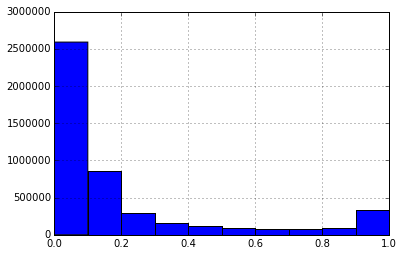

In [25]:
pv_df_final['proba_in_t'].hist()

In [27]:
# Add missing label to pv_df_final
missing_articles_file = os.path.join(cp.get('general', 'local_data_dir'), exp_dir, cp.get('missing', 'missing_items'))
d_missing = pd.read_csv(missing_articles_file, sep='\t', names = ['id', 'title_s', 'pageview_count_s'], encoding = 'utf8')
pv_df_final.index = pv_df_final['id']
d_missing.index = d_missing['id']
d_missing['missing'] = 1
pv_df_final['missing'] = d_missing['missing']
pv_df_final['missing'] = pv_df_final['missing'].fillna(0)

In [211]:
not_in_t = pv_df_final[pv_df_final['in_t'] == 0]
merged = not_in_t[not_in_t['missing'] == 0]['title']
del not_in_t

In [28]:
pv_df_final.sort( ['proba_in_t', 'predicted_target_rank'], ascending = [0, 0], inplace=True)
pv_df_final[pv_df_final['missing'] == 1].head(100)[['title', 'proba_in_t', 'predicted_target_rank', 'in_t', 'missing']]

,title,proba_in_t,predicted_target_rank,in_t,missing
id,,,,,
Q4735216,Alphabetical_list_of_comunes_of_Italy,1.000000,1.904408,0,1
Q11424,Film,1.000000,1.424123,0,1
Q1211457,Software_release_life_cycle,1.000000,1.371725,0,1
Q235065,Broadway_theatre,1.000000,1.340623,0,1
Q52954,Keyboard_instrument,1.000000,1.301301,0,1
Q852446,Political_divisions_of_the_United_States,1.000000,1.277820,0,1
Q2311683,ChemSpider,1.000000,1.159575,0,1
Q203250,International_Chemical_Identifier,1.000000,1.114853,0,1
Q715772,Captain_(association_football),1.000000,1.104564,0,1


In [29]:
pv_df_final.sort( ['predicted_target_rank', 'proba_in_t'], ascending = [0, 0], inplace=True)
pv_df_final[pv_df_final['missing'] == 1].head(100)[['title', 'proba_in_t', 'predicted_target_rank', 'in_t', 'missing']]

,title,proba_in_t,predicted_target_rank,in_t,missing
id,,,,,
Q6772702,Marquis_de_Sade_bibliography,0.212782,2.198990,0,1
Q7126609,Palais_des_Congrès,0.113117,2.113077,0,1
Q4967894,Brigitte_Jobbé-Duval,0.100570,2.042839,0,1
Q1862207,French_Ambassador_to_the_Ottoman_Empire,0.291312,2.032708,0,1
Q4952915,Boîte_à_Bonbons,0.117440,1.969229,0,1
Q16999261,Les_sept_âges_du_monde,0.052268,1.965618,0,1
Q6711056,Léon_Broutin,0.050991,1.964523,0,1
Q7925639,"Victor,_duc_de_Broglie",0.065639,1.963830,0,1
Q6622240,Lamoignon,0.125114,1.938980,0,1


# Not Converted Yet

In [23]:
# Save ranked missing items
ranked_missing_articles_file = os.path.join(cp.get('general', 'local_data_dir'), exp_dir, cp.get('missing', 'ranked_missing_items'))
d_missing.to_csv(ranked_missing_articles_file, sep='\t', encoding='utf-8')

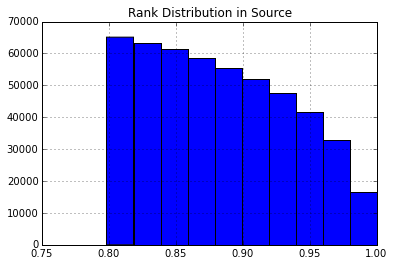

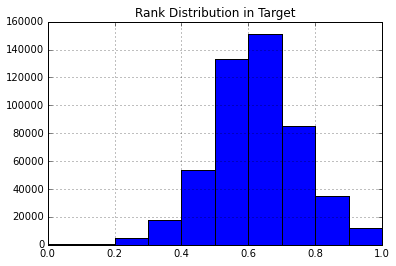

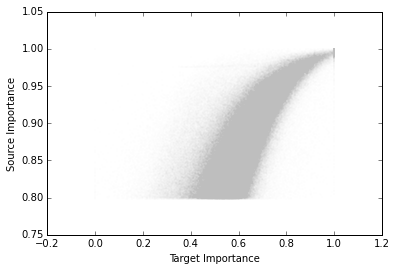

In [139]:
d_missing['rank_t'] = d_missing['rank_t'].apply(lambda x: min(1, max(0, x)))
plt.figure()
d_missing['rank_s'].hist()
plt.title('Rank Distribution in Source')
plt.figure()
d_missing['rank_t'].hist()
plt.title('Rank Distribution in Target')
plt.figure()
plt.scatter(d_missing['rank_t'], d_missing['rank_s'], s=1, facecolor='0.5', lw = 0, alpha = 0.05)
plt.xlabel('Target Importance')
plt.ylabel('Source Importance')

#Scratch

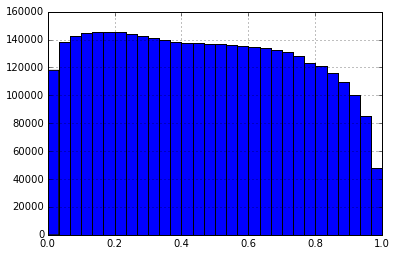

In [24]:
d_missing['rank_s'].hist(bins=30)

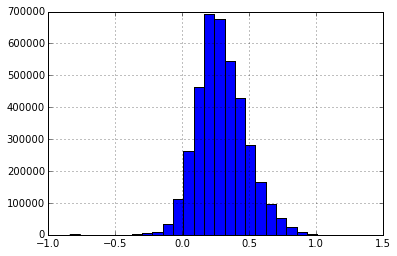

In [25]:
d_missing['rank_t'].hist(bins=30)

In [125]:

# compute spearman correlation between en as es ranks on missing articles
print "Baseline Spearman", spearmanr(d_missing_k['rank_en'], d_missing_k['rank_es'])

Baseline Spearman (0.76148637933899221, 0.0)


In [126]:
from sklearn.linear_model import Lasso
alg = Lasso()
param_grid = {'alpha': [0.000001, 0.0001, 0.001, 1]}
model = cv (X, y, 2, alg, param_grid)




Doing Gridsearch

MSE: 0.02139
R2: 0.73260
Spearman: 0.86140 

MSE: 0.02148
R2: 0.73211
Spearman: 0.86140 

MSE: 0.02309
R2: 0.71128
Spearman: 0.84927 

MSE: 0.02319
R2: 0.71080
Spearman: 0.84913 

MSE: 0.02639
R2: 0.66998
Spearman: 0.82518 

MSE: 0.02649
R2: 0.66964
Spearman: 0.82518 

MSE: 0.07998
R2: -0.00001
Spearman: nan 

MSE: 0.08019
R2: -0.00001
Spearman: nan 

Best Model Train MSE: 0.021394
Spearman: 0.86169 

Best Model Train Spearman 0.861693

Best parameters set found:
({'alpha': 1e-06}, 0.86140266086482908)


Grid scores:
0.86140 (+/-0.00000) for {'alpha': 1e-06}
0.84920 (+/-0.00003) for {'alpha': 0.0001}
0.82518 (+/-0.00000) for {'alpha': 0.001}
nan (+/-nan) for {'alpha': 1}


In [62]:
model.best_estimator_

Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute='auto', tol=0.0001,
   warm_start=False)

In [54]:
from sklearn.ensemble import RandomForestRegressor
alg = RandomForestRegressor()
param_grid = {'n_jobs' : [8], 'n_estimators' : [50, 500 ], 'max_depth' : [2, 3, 4 ] }
cv (X, y, 2, alg, param_grid)




Doing Gridsearch

Best Model Train MSE: 0.024215

Best parameters set found:
({'n_estimators': 50, 'n_jobs': 8, 'max_depth': 4}, -0.024152132858999739)


Grid scores:
-0.03364 (+/-0.00021) for {'n_estimators': 50, 'n_jobs': 8, 'max_depth': 2}
-0.03378 (+/-0.00018) for {'n_estimators': 500, 'n_jobs': 8, 'max_depth': 2}
-0.02695 (+/-0.00007) for {'n_estimators': 50, 'n_jobs': 8, 'max_depth': 3}
-0.02700 (+/-0.00005) for {'n_estimators': 500, 'n_jobs': 8, 'max_depth': 3}
-0.02415 (+/-0.00003) for {'n_estimators': 50, 'n_jobs': 8, 'max_depth': 4}
-0.02424 (+/-0.00008) for {'n_estimators': 500, 'n_jobs': 8, 'max_depth': 4}


GridSearchCV(cv=sklearn.cross_validation.KFold(n=70617, n_folds=2, shuffle=True, random_state=None),
       estimator=RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=10, n_jobs=1, oob_score=False,
           random_state=None, verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [50, 500], 'n_jobs': [8], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_squared_error', verbose=0)

In [57]:
from sklearn.linear_model import LinearRegression
alg = Lasso()
param_grid = {}
model = cv (rank_en.toarray(), y, 2, alg, param_grid)





Doing Gridsearch

Best Model Train MSE: 0.080153

Best parameters set found:
({}, -0.080153485281797415)


Grid scores:
-0.08015 (+/-0.00002) for {}


In [59]:
from sklearn.linear_model import LinearRegression
alg = Lasso()
param_grid = {}
model = cv (M_r.toarray(), y, 2, alg, param_grid)





Doing Gridsearch

Best Model Train MSE: 0.080153

Best parameters set found:
({}, -0.080153429784761906)


Grid scores:
-0.08015 (+/-0.00011) for {}
